In [1]:
%matplotlib inline 
import sys, os
base_path = os.getcwd()[0:os.getcwd().rfind('Watermark')] + "Watermark/"
sys.path.append(base_path) 

import matplotlib.pyplot as plt
from src.asiaccs_main import asiaccs_blackbox
from src.models import get_deep_cnn_for_cifar, get_lenet_model_for_mnist
from src.preprocess_data import load_cifar_images, load_mnist_images

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# Description
In this notebook we are running a surrogate model attack. The attacker and owner data is disjoint.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[1/5] (gaussian) Blackbox Attack: Loading CIFAR data
      Owner data: 100000 Attacker Data: 100000
     Found cached training data for owner_data100000100000
     Found cached training data for attacker_data100000100000
[2/5] Generating ASIACCS watermarked images: Train(10000) Test(1000)
Embedding gaussian watermarks
(Gaussian) Plot class: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Gaussian) Plot class: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


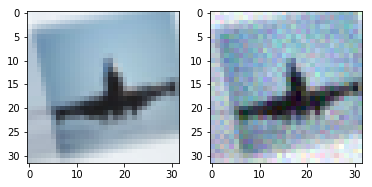

Embedding gaussian watermarks
(Gaussian) Plot class: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Gaussian) Plot class: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


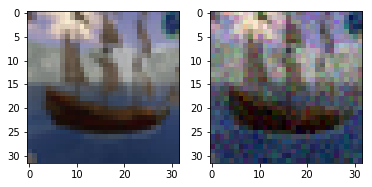

[3/5] Training the original model and embedding the watermark
Instructions for updating:
Use tf.cast instead.
      Skipping embedding of wm and use a cached entry instead
100000/100000 [==============================] - 76s 757us/step
    Done! Original models accuracy on attackers data: 0.81037
[4/5] Labeling the attackers data with the original model
[5/5] Training the surrogate model
Train on 100000 samples, validate on 10000 samples
Epoch 1/15
100000/100000 [==============================] - 316s 3ms/step - loss: 1.2040 - acc: 0.6022 - val_loss: 0.8595 - val_acc: 0.7112
=> Time: : 316.1752827167511
=> watermark_new_val: 0.069
Confusion matrix, without normalization


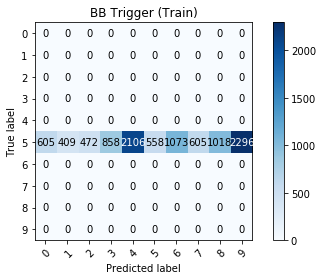

Confusion matrix, without normalization


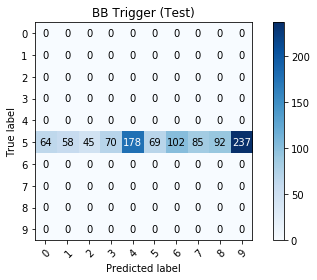

=> watermark_val: 0.0558
Epoch 2/15
 89664/100000 [=========================>....] - ETA: 31s - loss: 0.7261 - acc: 0.7648

In [ ]:
surr_model, all_history = asiaccs_blackbox(
     load_dataset_func=load_cifar_images,  # Which dataset to choose. Should return training and testing data
     dataset_label="CIFAR",  # Label of the dataset (for caching)
     model=get_deep_cnn_for_cifar(),  # Model specification for wm_embedding
     surrogate_model=get_deep_cnn_for_cifar(),
     wm_type="gaussian",
     owner_data_size=25000,
     total_owner_data_size=100000,
     key_length=10000,
     key_length_test=1000,
     attacker_data_size=25000,
     total_attacker_data_size=100000,
     epochs_embed=20,
     epochs_surr=15,
     batchsize_surr=64,
     cache_embed_wm="asiaccs_gaussian_cifar",
     cache_surr_model=None,
     verbose=True
)

In [ ]:
embed_history, surr_history = all_history
for history in all_history:
    print(history.history.keys())
    
last_index = 17
surr_history_cut = {}
surr_history_cut["watermark_val"] = surr_history.history["watermark_val"][:last_index]
surr_history_cut["val_acc"] = surr_history.history["val_acc"][:last_index]
surr_history_cut["time"] = surr_history.history["time"][0:last_index]

plt.figure(figsize=(20,10))
params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'font.size': 16}
test_acc_color = "navy"
linestyle_test_acc = "x-"
linestyle_watermark = "x--"
watermark_ret_color = "green"
watermark_ret_color2 = "green"
linewidth = 3.0
markersize = 12

# Create the x axis by joining together all time values
time_arr = embed_history.history['time']
x_axis_time = []
for i in range(0, len(time_arr)):
    t = time_arr[i]
    for j in range(0,i):
        t += time_arr[j]
    x_axis_time.append(t/60)
offset = x_axis_time[-1]
print(offset)
time_arr2 = surr_history_cut['time']
for i in range(0, len(time_arr2)):
    t = time_arr2[i]
    for j in range(0,i):
        t += time_arr2[j]
    x_axis_time.append(t/60+offset)
print(x_axis_time)
    
plt.xlabel('Time in min', fontsize=26)
plt.ylabel('Accuracy', fontsize=26)

lh1, lh2 = len(embed_history.history['val_acc']), len(surr_history_cut['watermark_val'])
plt.plot(x_axis_time[:lh1], embed_history.history['val_acc'], linestyle_test_acc, linewidth=linewidth, markersize=markersize, color=test_acc_color)
plt.plot(x_axis_time[:lh1], embed_history.history['watermark_val'], linestyle_watermark, linewidth=linewidth, markersize=markersize, color=watermark_ret_color2)

plt.plot(x_axis_time[-lh2:], surr_history_cut['val_acc'], linestyle_test_acc, linewidth=linewidth, markersize=markersize, color=test_acc_color)
plt.plot(x_axis_time[-lh2:], surr_history_cut['watermark_val'], linestyle_watermark, linewidth=linewidth, markersize=markersize, color=watermark_ret_color2)

plt.axvline(x_axis_time[len(embed_history.history['val_acc'])-1], linestyle=':', linewidth=linewidth, color='red')

# Annotate data points for surrogate model 
dat_y = surr_history_cut['val_acc']
dat_x = x_axis_time[-lh2:]
ctr = 0
for xy in zip(dat_x, dat_y):    
    if ctr % 3 == 0 or ctr == len(dat_y)-1:
        plt.annotate("{:.3f}".format(xy[1]), xy=(xy[0], xy[1]+0.02), textcoords='data', fontsize=14) # <--  
    ctr += 1

# Annotate data points for watermark model 
dat_y = embed_history.history['val_acc']
dat_x = x_axis_time[:lh1]
ctr = 0
for xy in zip(dat_x, dat_y):    
    if ctr % 3 == 0 or ctr == len(dat_y):
        plt.annotate("{:.3f}".format(xy[1]), xy=(xy[0], xy[1]+0.02), textcoords='data', fontsize=14) # <--  
    ctr += 1

plt.ylim(0,1.05)
plt.xlim(0)

plt.grid()

plt.legend(['test accuracy', 'wm retention'], loc='lower left')
plt.show()